In [2]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable

from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

In [9]:
import shapefile

In [16]:
sf_dir = "World_EEZ_v10_20180221_HR_0_360/"
sf = shapefile.Reader(sf_dir+"World_EEZ_v10_2018_0_360")
fields = sf.fields
records = sf.records

In [21]:
fields

[('DeletionFlag', 'C', 1, 0),
 ['cat', 'N', 9, 0],
 ['MRGID', 'N', 24, 15],
 ['GeoName', 'C', 90, 0],
 ['MRGID_Ter1', 'N', 24, 15],
 ['Pol_type', 'C', 80, 0],
 ['MRGID_Sov1', 'N', 24, 15],
 ['Territory1', 'C', 80, 0],
 ['ISO_Ter1', 'C', 80, 0],
 ['Sovereign1', 'C', 80, 0],
 ['MRGID_Ter2', 'N', 24, 15],
 ['MRGID_Sov2', 'N', 24, 15],
 ['Territory2', 'C', 80, 0],
 ['ISO_Ter2', 'C', 80, 0],
 ['Sovereign2', 'C', 80, 0],
 ['MRGID_Ter3', 'N', 24, 15],
 ['MRGID_Sov3', 'N', 24, 15],
 ['Territory3', 'C', 80, 0],
 ['ISO_Ter3', 'C', 80, 0],
 ['Sovereign3', 'C', 80, 0],
 ['x_1', 'N', 24, 15],
 ['y_1', 'N', 24, 15],
 ['MRGID_EEZ', 'N', 24, 15],
 ['Area_km2', 'N', 24, 15]]

In [20]:
sf.record(1)

Record #1: [229, 26526.0, 'Sint-Eustatius Exclusive Economic Zone', 26525.0, '200NM', 15.0, 'Sint-Eustatius', 'BES', 'Netherlands', 0.0, 0.0, '', '', '', 0.0, 0.0, '', '', '', -63.1298700042, 17.3389023869, 26526.0, 2183.0]

In [3]:
POP_dir = '/scratch/DaanR/fields/pop_01deg_monthly/'
POP_files = sorted(glob(POP_dir+'t.t0.1_42l_nccs01.03??????_monthly.nc'))
mesh = '/scratch/DaanR/fields/grid_coordinates_pop_tx0.1.nc'

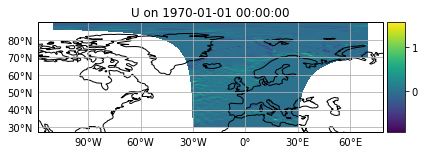

In [4]:
# Load and add velocity field
def read_fieldset_highres(ufiles):
    filenames = {'U': {'lon': mesh,
                       'lat': mesh,
                       'data':ufiles},
                 'V': {'lon': mesh,
                       'lat': mesh,
                       'data':ufiles}}

    variables = {'U': 'UVEL',
                 'V': 'VVEL'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'U_LAT_2D',
                        'lon': 'U_LON_2D'},
                  'V': {'time': 'time',
                        'lat': 'U_LAT_2D',
                        'lon': 'U_LON_2D'}}

    # Use indices to load a subset of the fields. This saves internal memory.
    indices = {'lon': range(800,1400), 'lat': range(1500, 2400)} # North?
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices=indices, allow_time_extrapolation=False)

    fieldset.U.set_scaling_factor(0.01)  #convert cm/s to m/s
    fieldset.V.set_scaling_factor(0.01)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    return fieldset

fieldset = read_fieldset_highres(POP_files)  
fieldset.U.show()

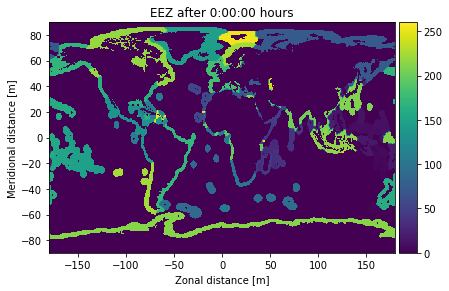

In [5]:
# Load and add EEZ field
EEZ_ds = xr.open_dataset('EEZ.nc4')
EEZ = EEZ_ds['EEZ'][2,:,:]
EEZ_lats = EEZ_ds['CenterLat'].data
EEZ_lons = EEZ_ds['CenterLong'].data

EEZ_field = Field(name="EEZ", data=EEZ.data, lon=EEZ_lons, lat=EEZ_lats, allow_time_extrapolation=True)
fieldset.add_field(EEZ_field)

fieldset.EEZ.show()

In [6]:
# Kernels and particleclasses
class myParticle(JITParticle):
        EEZ = Variable('EEZ', dtype=np.int32, to_write=True)

def EEZ_sampler(particle, fieldset, time):
    particle.EEZ = fieldset.EEZ[time, 0., particle.lat, particle.lon]

def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [7]:
# Specify release times and locations
release_times = np.array([datetime(1970, 1, 1) + delta(days=x) for x in range(0, int(365*1),3)])
release_lons = np.full(len(release_times), 3)
release_lats = np.full(len(release_times), 66)

In [7]:
# Initialize and run fieldset
pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=release_lons, lat=release_lats, 
                       time = release_times)
pfile = ParticleFile('pFileEEZ', pset, outputdt=delta(hours=6))
kernels = pset.Kernel(AdvectionRK4) + EEZ_sampler
pset.execute(kernels, \
             runtime=delta(days=365), \
             dt = delta(minutes=5), \
             output_file = pfile, \
             verbose_progress = True, \
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled myParticleAdvectionRK4EEZ_sampler ==> /tmp/parcels-23300/79c59920d42e2cc2ebdf5ca7499d58d1.so
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:03:10 Time:  0:03:10


In [8]:
plotTrajectoriesFile('pFileEEZ.nc', mode='movie2d_notebook')

In [11]:
# Investigate data. Which EEZs are visited?
pfile = xr.open_dataset('pFileEEZ.nc', decode_cf=True)
uniques, counts = np.unique(np.where(np.isnan(pfile['EEZ'].data), -1, pfile['EEZ'].data), return_counts=True)
bardict = dict(zip(uniques, counts))
str(np.ma.filled(pfile.variables['time'], np.nan)[0][0])[:13]

'1970-01-01T00'

In [13]:
def particle_anim(pfile, fps=24):
    # Load arrays from file
    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)
    time = np.ma.filled(pfile.variables['time'], np.nan)
    EEZ_evol = np.ma.filled(pfile.variables['z'], np.nan)
    mesh = pfile.attrs['parcels_mesh'] if 'parcels_mesh' in pfile.attrs else 'spherical'
    pfile.close()
    
    # Create figure
    fig     = plt.figure(figsize=(9,5))
    particle_map = plt.subplot(projection=ccrs.PlateCarree())   
    
    # Add background for land plot
    particle_map.set_extent((-10,20,50,80), crs=ccrs.PlateCarree())
    particle_map.coastlines()
    particle_map.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
    particle_map.pcolor(EEZ_lons, EEZ_lats, EEZ, transform=ccrs.PlateCarree(), cmap='Set3', zorder=1)
    gl = particle_map.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plottimes = np.unique(time)
    if isinstance(plottimes[0], (np.datetime64, np.timedelta64)):
        plottimes = plottimes[~np.isnat(plottimes)]
    else:
        try:
            plottimes = plottimes[~np.isnan(plottimes)]
        except:
            pass
    currtime = time == plottimes[0]
    
    scat   = particle_map.scatter(lon[currtime], lat[currtime], s=20, color='k', transform=ccrs.Geodetic())
    
    # Specify EEZs for bar chart
    targets = [0, 210, 218, 223] # -1 for NaN
    # Count instances of particles at EEZ in target list at a certain timestep
    def EEZ_counter(timestep):
        currEEZ = np.where(np.isnan(pfile['EEZ'].data[timestep]), -1, pfile['EEZ'].data[timestep])
        currCount = np.zeros(len(targets))
        for el in currEEZ:
            try:
                idx = targets.index(el)
                currCount[idx] += 1
            except ValueError:
                pass
        return currCount
    
    divider = make_axes_locatable(particle_map)
    barplot = divider.append_axes("right", size=2, pad=1, axes_class=plt.Axes)
    
    bar    = barplot.barh(np.arange(len(targets)), EEZ_counter(currtime))
    barplot.set_xlim(0, 40)
    barplot.set_yticks(np.arange(len(targets)))
    barplot.set_yticklabels(['No EEZ' if label == -1 else str(label) for label in targets])
    barplot.set_ylabel('EEZ ID')
    barplot.set_xlabel('Count')
    barplot.invert_yaxis()
    titel = fig.suptitle('Particles at time ' + str(plottimes[0])[:13])
    frames = np.arange(0, len(plottimes))

    def animate(t):
        currtime = time == plottimes[t]
        scat.set_offsets(np.vstack((lon[currtime], lat[currtime])).transpose())
        titel.set_text('Particles in different EEZs at time ' + str(plottimes[t])[:13])
        for rect, width in zip(bar, EEZ_counter(currtime)):
            rect.set_width(width)
        return scat,
    anim = animation.FuncAnimation(fig, animate, interval=20, blit=False)  #Frames, init_func=init
    anim.save('particle_EEZ_evo.mp4', fps=fps, metadata={'artist':'Daan', 'title':'Particles in EEZs'}, extra_args=['-vcodec', 'libx264'])
    
    plt.show()
    plt.close()

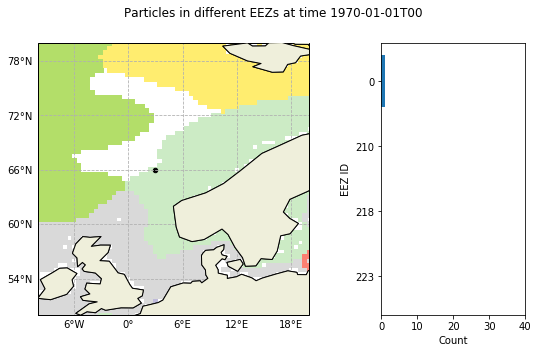

In [14]:
particle_anim(pfile)